# Real Hardware Fitting

In [67]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

## Expectation Value

## Two Qubit POVM with Trace

In [33]:
def variational_circuit(n):
    theta = np.random.uniform(-np.pi, np.pi, 4*n)
    circuit = qk.QuantumCircuit(n)
    for i, angle in enumerate(theta[:n]):
        circuit.ry(angle, i)
    
    for i, angle in enumerate(theta[n:2*n]):
        circuit.crx(angle, i, (i+1)%n)
        
    #for i, angle in enumerate(theta[2*n:3*n]):
    #    circuit.ry(angle, i)
        
    #for i, angle in enumerate(theta[3*n:]):
    #    circuit.crx(angle, (n-i)%n, n-i-1)
    
    return circuit

In [34]:
n = 2
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_expectation_POVM.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)
print(sum(povm))
print(corr_mat)

tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(4, 4), dtype=complex64)
[[9.846e-01 3.330e-02 2.199e-02 8.750e-04]
 [7.012e-03 9.588e-01 8.750e-05 2.139e-02]
 [8.400e-03 3.375e-04 9.708e-01 3.230e-02]
 [1.250e-05 7.537e-03 7.075e-03 9.454e-01]]


In [35]:
target_list = []
input_list_ = []
for input, counts in zip(input_list, counts_list):
    target_list.append(counts_to_probs(counts))
    state, U_basis, obs = input
    input_list_.append([tf.cast(state, dtype=tf.complex64), tf.cast(U_basis, dtype=tf.complex64), obs])

input_list = input_list_

input_train, input_test = input_list[:300],input_list[300:]
target_train, target_test = target_list[:300], target_list[300:]

In [36]:
n = 2
d = 2**n
rank = 8
np.random.seed(42)
random.seed(42)

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm_ideal(n),
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        input_list = input_list,
                        target_list = target_list,
                        input_val_list = input_list,
                        target_val_list = target_list,
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

In [41]:
model.train(num_iter = 400,
            N = 100
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0 (0.00017850763+1.3330793e-11j)
1 (0.00017871348-1.4131037e-11j)
2 (0.00017898015+1.6102513e-12j)
3 (0.00017816864-1.3215606e-11j)
4 (0.00017662742+1.6373477e-11j)
5 (0.00017529666+3.4310357e-11j)
6 (0.00017427251+7.142424e-12j)
7 (0.00017303409-1.6604997e-11j)
8 (0.00017228514+2.0201079e-11j)
9 (0.00017211447+3.166657e-11j)
10 (0.00017188131+1.6467667e-12j)
11 (0.00017186654-1.5329675e-11j)
12 (0.00017190853-6.6421677e-12j)
13 (0.00017178181+4.403459e-12j)
14 (0.00017114024+3.1208243e-12j)
15 (0.0001705505+2.2576585e-11j)
16 (0.00016988562+1.0693168e-11j)
17 (0.00016962983-1.3925636e-11j)
18 (0.00016912806+1.5810191e-12j)
19 (0.0001683439+9.514424e-12j)
20 (0.00016770136+5.020113e-12j)
21 (0.00016718166-2.924668e-12j)
22 (0.00016608546+1.0129175e-11j)
23 (0.00016519973+1.3863596e-11j)
24 (0.00016430713+8.403828e-12j)
25 (0.0001636877+3.600555e-12j)
26 (0.0001636994+1.3336158e-11j)
27 (0.00016370104-1.7331442e-11j)
28 (0.00016347042-4.5207115e-12j)
29 (0.00016320735-1.8152613e-11j)
30

In [42]:
state_unitary = state_model = np.zeros((d,d))
state_unitary[0,0] = 1

state_unitary = tf.cast(state_unitary, dtype=tf.complex64)
state_model = tf.cast(state_model, dtype=tf.complex64)

observ = np.zeros(d)
observ[0] = 1
observ = tf.cast(observ, dtype=tf.complex64)
model_expectation_list = []
unitary_expectation_list = []

target_test = [expectation_value(counts_to_probs(counts), observ) for counts in counts_list[324:-d**2]]
counts_list[324:-d**2]


for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    model_expectation_list.append(expectation_value(measurement(state_model, povm=model.q_map.povm), observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.povm), observ))

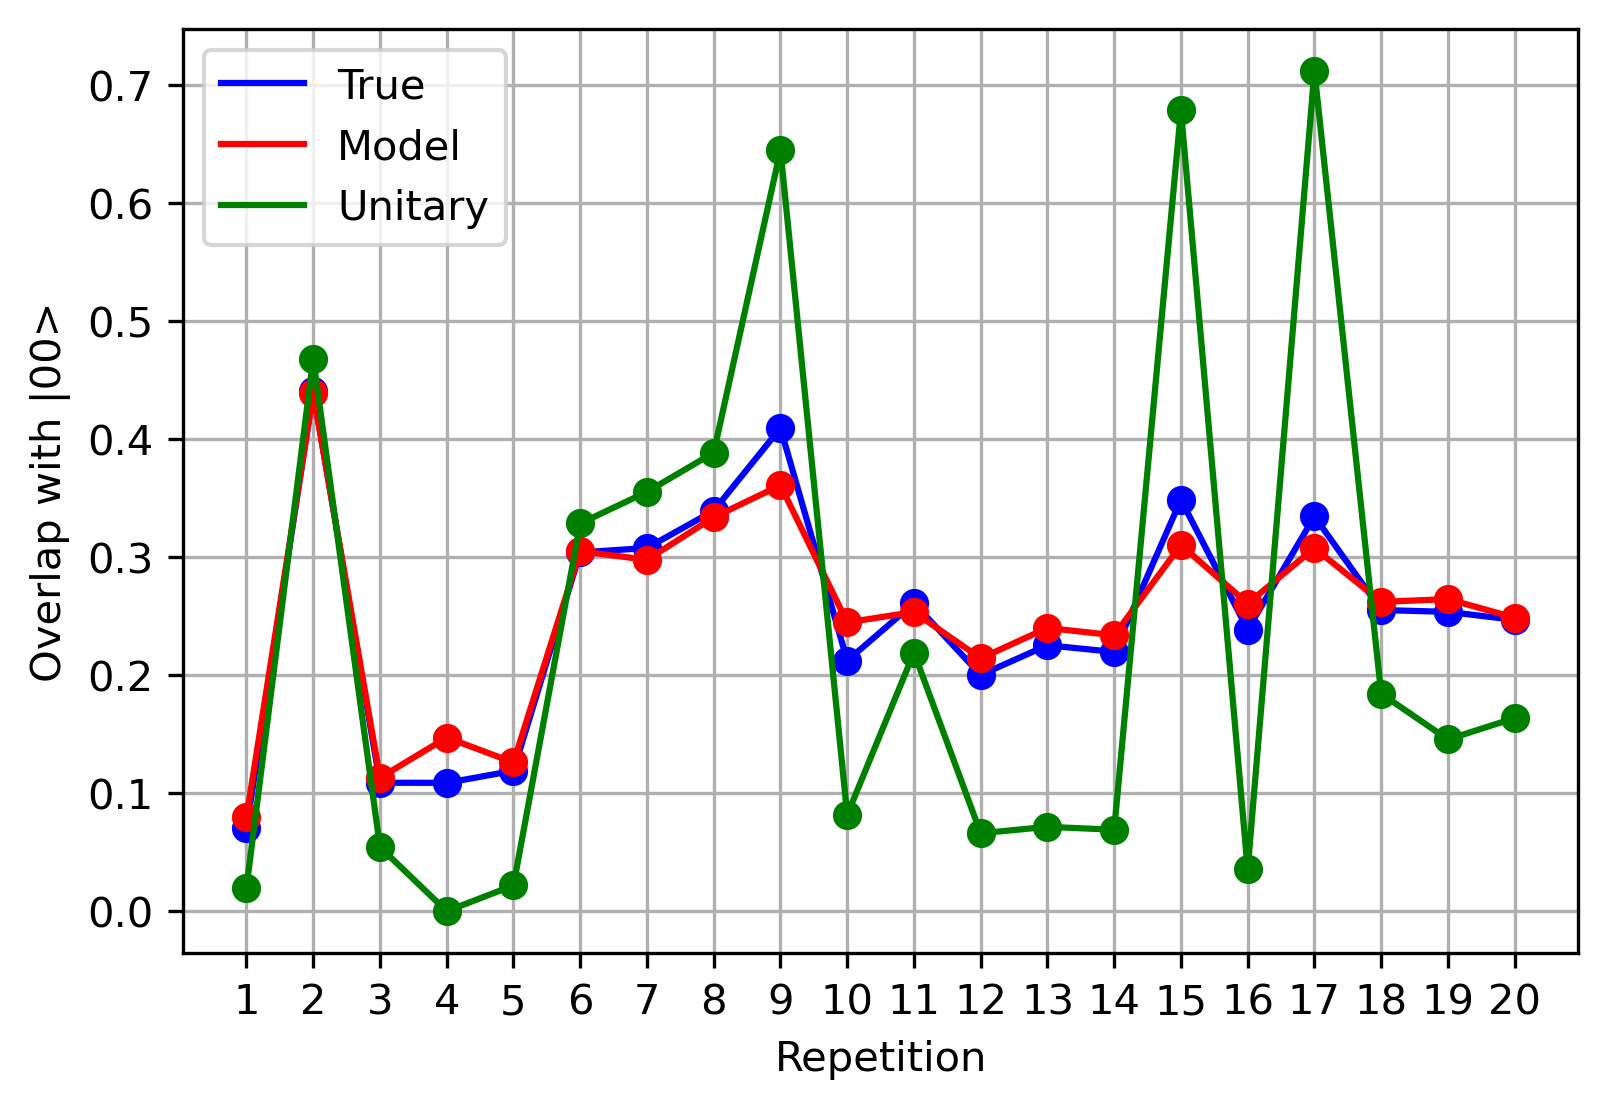

In [44]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

## Three Qubits 

In [7]:
n = 3
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\threeQubits_expectation_POVM.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)
print(sum(povm))
print(corr_mat)

tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(8, 8), dtype=complex64)
[[9.722e-01 3.256e-02 2.147e-02 7.250e-04 2.316e-02 8.563e-04 5.437e-04
  0.000e+00]
 [7.150e-03 9.471e-01 1.687e-04 2.112e-02 1.563e-04 2.216e-02 1.250e-05
  4.375e-04]
 [7.613e-03 2.625e-04 9.583e-01 3.113e-02 1.250e-04 0.000e+00 2.188e-02
  7.000e-04]
 [6.875e-05 7.206e-03 7.044e-03 9.339e-01 6.250e-06 1.750e-04 1.812e-04
  2.143e-02]
 [1.279e-02 3.500e-04 2.813e-04 3.125e-05 9.625e-01 3.133e-02 2.167e-02
  6.375e-04]
 [1.000e-04 1.244e-02 0.000e+00 3.125e-04 6.731e-03 9.376e-

In [8]:
target_list = []
input_list_ = []
for input, counts in zip(input_list, counts_list):
    target_list.append(counts_to_probs(counts))
    state, U_basis, obs = input
    input_list_.append([tf.cast(state, dtype=tf.complex64), tf.cast(U_basis, dtype=tf.complex64), obs])

input_list = input_list_

input_train, input_test = input_list[:900],input_list[900:]
target_train, target_test = target_list[:900], target_list[900:]

In [9]:
rank = 8
np.random.seed(42)
random.seed(42)

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        input_list = input_train,
                        target_list = target_train,
                        input_val_list = input_test,
                        target_val_list = target_test,
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

In [27]:
model.train(num_iter = 200,
            N = 100
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0 (0.00039736996-1.9506468e-11j)
1 (0.0003957152-1.0547483e-11j)
2 (0.0003947735+3.709204e-12j)
3 (0.0003943491+4.265845e-12j)
4 (0.00039264187-7.1091262e-12j)
5 (0.0003914579-6.02445e-12j)
6 (0.0003893847-1.4890558e-11j)
7 (0.0003873195+7.286838e-12j)
8 (0.00038589124-8.303533e-12j)
9 (0.0003868512-5.097173e-12j)
10 (0.00038862153+2.9334743e-11j)
11 (0.0003893506+2.974085e-11j)
12 (0.00039033443+2.2449239e-11j)
13 (0.0003921992-2.6125158e-11j)
14 (0.00039321557-2.1899746e-11j)
15 (0.0003950086+1.21962275e-11j)
16 (0.00039589006-7.2304567e-12j)
17 (0.00039652048+1.3918786e-11j)
18 (0.00039637173-8.977992e-12j)
19 (0.0003953897+2.767032e-11j)
20 (0.00039423993+4.50473e-15j)
21 (0.00039348882-9.0364977e-13j)
22 (0.0003928637-4.1197917e-11j)
23 (0.00039273535-1.82001e-12j)
24 (0.0003923589-5.8762426e-12j)
25 (0.00039194396-2.312819e-11j)
26 (0.00039199344+2.4587077e-11j)
27 (0.0003923187+1.4728347e-12j)
28 (0.00039161448-2.8525485e-12j)
29 (0.00038934348-4.0114183e-11j)
30 (0.00038788654+

In [28]:
state_unitary = state_model = np.zeros((d,d))
state_unitary[0,0] = 1

state_unitary = tf.cast(state_unitary, dtype=tf.complex64)
state_model = tf.cast(state_model, dtype=tf.complex64)

observ = np.zeros(d)
observ[0] = 1
observ = tf.cast(observ, dtype=tf.complex64)
model_expectation_list = []
unitary_expectation_list = []

target_test = [expectation_value(counts_to_probs(counts), observ) for counts in counts_list[1000:-d**2]]


for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    probs = measurement(state_model, povm=model.q_map.povm)
    model_expectation_list.append(expectation_value(probs, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    probs = measurement(state_unitary, povm=model.q_map.povm)
    unitary_expectation_list.append(expectation_value(probs, observ))

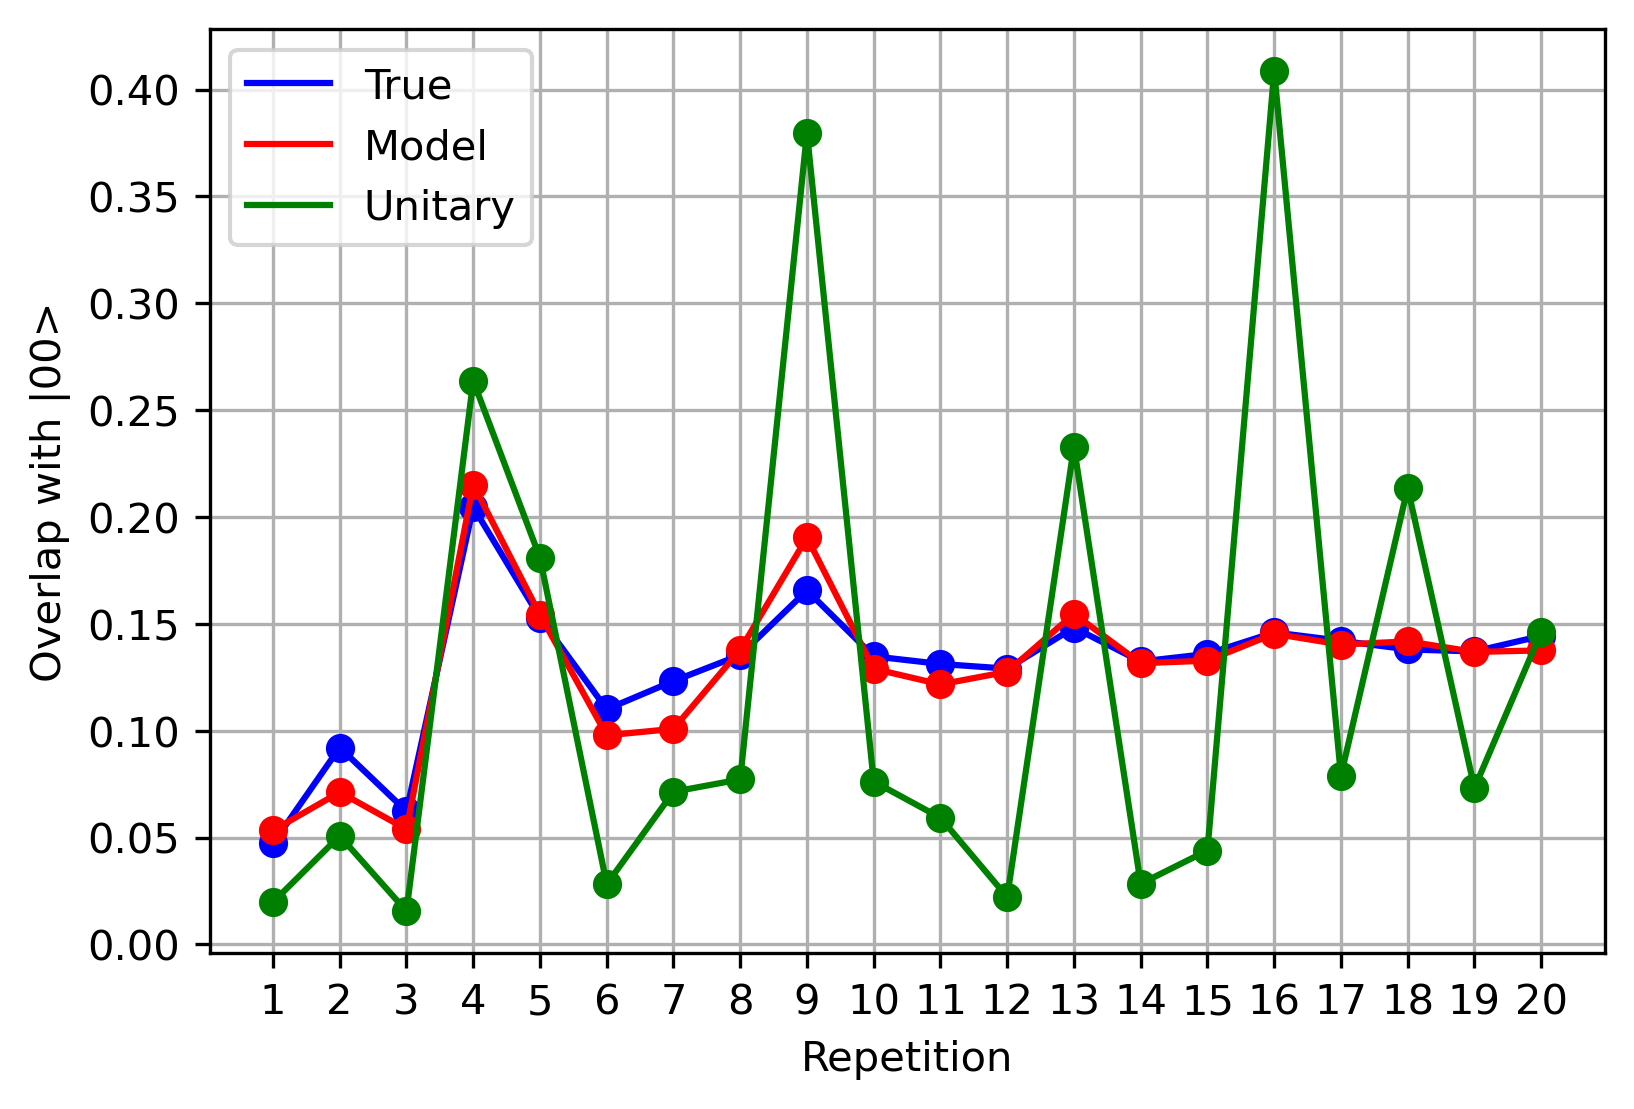

In [32]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

## Two Qubits, Two Blocks

In [46]:
n = 2
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\twoQubits_twoBlocks.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)
print(sum(povm))
print(corr_mat)

tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(4, 4), dtype=complex64)
[[9.849e-01 3.352e-02 2.165e-02 7.500e-04]
 [7.375e-03 9.593e-01 1.500e-04 2.075e-02]
 [7.675e-03 2.750e-04 9.713e-01 3.321e-02]
 [3.750e-05 6.900e-03 6.900e-03 9.453e-01]]


In [47]:
target_list = []
input_list_ = []
for input, counts in zip(input_list, counts_list):
    target_list.append(counts_to_probs(counts))
    state, U_basis, obs = input
    input_list_.append([tf.cast(state, dtype=tf.complex64), tf.cast(U_basis, dtype=tf.complex64), obs])

input_list = input_list_

input_train1, input_train2 = input_list[:324], input_list[324:]
target_train1, target_train2 = target_list[:324], target_list[324:]

In [50]:
rank = 8
np.random.seed(42)
random.seed(42)

np.random.seed(42)
random.seed(42)

kraus_model1 = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model1 = ModelQuantumMap(
                        q_map = kraus_model1,
                        loss = probs_loss,
                        input_list = input_train1,
                        target_list = target_train1,
                        input_val_list = input_train1,
                        target_val_list = target_train1,
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

kraus_model2 = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model2 = ModelQuantumMap(
                        q_map = kraus_model2,
                        loss = probs_loss,
                        input_list = input_train2,
                        target_list = target_train2,
                        input_val_list = input_train2,
                        target_val_list = target_train2,
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

In [51]:
model1.train(num_iter = 200,
             N = 50
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0 (0.16088393-1.7659938e-09j)
1 (0.1540824+3.825226e-09j)
2 (0.14633852-9.611952e-10j)
3 (0.13860105-1.0229146e-09j)
4 (0.13124155-3.222299e-10j)
5 (0.12365901+2.2764496e-10j)
6 (0.115940586+2.5532636e-09j)
7 (0.108910516+3.3140188e-10j)
8 (0.10205801+1.1339542e-09j)
9 (0.09523397-1.070408e-09j)
10 (0.08854989+5.285124e-10j)
11 (0.0820225+1.3826174e-09j)
12 (0.07561772+1.4166252e-09j)
13 (0.06939684+1.3432019e-09j)
14 (0.06327943+1.801063e-10j)
15 (0.057647735+1.3649378e-09j)
16 (0.052199617+8.5500107e-10j)
17 (0.04704793+1.0874297e-09j)
18 (0.04236905+8.1238466e-10j)
19 (0.038102437+1.7843696e-10j)
20 (0.03431614+1.7696135e-10j)
21 (0.030909605+2.4633173e-10j)
22 (0.027877782-2.1911714e-10j)
23 (0.025100576-9.593596e-12j)
24 (0.022637896+3.8428397e-10j)
25 (0.02038013+2.0533843e-10j)
26 (0.018265026+3.638152e-10j)
27 (0.016349813+1.7196768e-10j)
28 (0.014585815+4.6187623e-10j)
29 (0.013036868+4.662687e-10j)
30 (0.011686813+8.648981e-11j)
31 (0.010502293+2.2856173e-10j)
32 (0.009499387

In [52]:
model2.train(num_iter = 200,
             N = 50
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0 (0.12813908+2.788751e-09j)
1 (0.12255961+4.168099e-10j)
2 (0.11659204+3.3612235e-10j)
3 (0.11058065+8.4695195e-10j)
4 (0.10478363-2.158649e-09j)
5 (0.09907493-1.5835505e-10j)
6 (0.093585394+2.0377686e-10j)
7 (0.08821168-6.2780936e-10j)
8 (0.08311079-2.9424793e-10j)
9 (0.07806813-1.4944658e-09j)
10 (0.07297039+1.6303309e-09j)
11 (0.06808696+1.1688103e-09j)
12 (0.06331306+6.0699773e-10j)
13 (0.058599308+8.7638935e-10j)
14 (0.053953305+2.9312378e-10j)
15 (0.049352936-1.7040044e-10j)
16 (0.045062512+6.0081573e-10j)
17 (0.040722966+4.0427478e-10j)
18 (0.03668654+7.701417e-11j)
19 (0.03303958-4.2134232e-10j)
20 (0.029659104+6.6466804e-10j)
21 (0.026567686+2.0806226e-10j)
22 (0.023713782+3.1603206e-10j)
23 (0.021127928+2.3349805e-10j)
24 (0.01882107+2.1929691e-10j)
25 (0.016715601-1.1079079e-10j)
26 (0.014785752+3.567701e-11j)
27 (0.013079108+2.6464944e-10j)
28 (0.011547303+1.0906992e-11j)
29 (0.010186191-6.9544227e-12j)
30 (0.009004511-8.87986e-11j)
31 (0.007979087+3.7045508e-10j)
32 (0.00

In [68]:
state = np.zeros((d,d))
state[0,0] = 1
state = tf.cast(state, dtype=tf.complex64)

observ = np.zeros(d)
observ[0] = 1
observ = tf.cast(observ, dtype=tf.complex64)

state = model1.q_map.apply_map(state)
state = model2.q_map.apply_map(state)
probs_model = np.abs(measurement(state, povm = povm).numpy())

probs_true = counts_to_probs(counts_list[2*324])

print("Model:", probs_model)
print("True:", probs_true)

Model: [0.2396 0.1313 0.0692 0.5598]
True: [0.2354 0.1333 0.0698 0.5615]


## Three Qubits, Two Blocks

In [83]:
n = 3
d = 2**n
input_list, counts_list = pickle.load(open("..\..\data\threeQubits_twoBlocks.p", "rb"))
counts_error = counts_list[-d**2:]
corr_mat = sum([generate_corruption_matrix(counts_error[d*i:d*(i+1)]) for i in range(d)])/d
povm = corr_mat_to_povm(corr_mat)
print(sum(povm))
print(corr_mat)

tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(8, 8), dtype=complex64)
[[9.7204e-01 3.1762e-02 2.1719e-02 8.0000e-04 2.2550e-02 7.0625e-04
  4.2500e-04 2.5000e-05]
 [7.1562e-03 9.4722e-01 1.5625e-04 2.1519e-02 1.8750e-04 2.2356e-02
  0.0000e+00 5.0000e-04]
 [7.5562e-03 2.3125e-04 9.5831e-01 3.1962e-02 2.1250e-04 6.2500e-06
  2.2394e-02 6.6875e-04]
 [8.1250e-05 7.6125e-03 7.0625e-03 9.3317e-01 6.2500e-06 1.5625e-04
  1.3750e-04 2.2256e-02]
 [1.2987e-02 3.5625e-04 2.3125e-04 2.5000e-05 9.6246e-01 3.1531e-02
  2.1681e-02 7.4375e-04]
 [7.5000e-05 1.2706

In [84]:
target_list = []
input_list_ = []
for input, counts in zip(input_list, counts_list):
    target_list.append(counts_to_probs(counts))
    state, U_basis, obs = input
    input_list_.append([tf.cast(state, dtype=tf.complex64), tf.cast(U_basis, dtype=tf.complex64), obs])

input_list = input_list_

input_train1, input_train2 = input_list[:1000], input_list[1000:]
target_train1, target_train2 = target_list[:1000], target_list[1000:]

In [85]:
rank = 16
np.random.seed(42)
random.seed(42)

np.random.seed(42)
random.seed(42)

kraus_model1 = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model1 = ModelQuantumMap(
                        q_map = kraus_model1,
                        loss = probs_loss,
                        input_list = input_train1,
                        target_list = target_train1,
                        input_val_list = input_train1[:100],
                        target_val_list = target_train1[:100],
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

kraus_model2 = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       povm = povm,
                       )

model2 = ModelQuantumMap(
                        q_map = kraus_model2,
                        loss = probs_loss,
                        input_list = input_train2,
                        target_list = target_train2,
                        input_val_list = input_train2[:100],
                        target_val_list = target_train2[:100],
                        optimizer = tf.optimizers.Adam(learning_rate=0.05),
                        )

In [86]:
model1.train(num_iter = 200,
             N = 50
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0 (0.06778678+2.2229826e-10j)
1 (0.06613042-1.0969534e-09j)
2 (0.06416332+5.397673e-10j)
3 (0.061914552+1.2468028e-10j)
4 (0.059539817+1.4819789e-09j)
5 (0.05719088-8.844924e-10j)
6 (0.054769896+8.426486e-10j)
7 (0.052291557-7.922631e-10j)
8 (0.049894616+3.8890208e-10j)
9 (0.047498766+1.6143754e-10j)
10 (0.04515725-7.872243e-11j)
11 (0.042867914-7.607959e-10j)
12 (0.040602125+4.4001194e-10j)
13 (0.038454592-3.561531e-10j)
14 (0.036332477-5.434269e-10j)
15 (0.034286708+2.6127434e-10j)
16 (0.032310445-5.5538385e-10j)
17 (0.030431977+6.1549776e-10j)
18 (0.028607368+3.1265027e-10j)
19 (0.026849868+1.5750411e-10j)
20 (0.025172196-2.9413738e-10j)
21 (0.023627594-1.0784523e-10j)
22 (0.022132326-2.2902535e-10j)
23 (0.020731123-2.9861297e-10j)
24 (0.01935546+3.0580583e-10j)
25 (0.018045597+1.2184535e-10j)
26 (0.01682686+2.0884679e-10j)
27 (0.015646288-4.258649e-10j)
28 (0.014541443-2.4224794e-10j)
29 (0.013523672+2.640417e-10j)
30 (0.012547825+3.1086023e-11j)
31 (0.011582191+1.7833353e-10j)
32 

In [87]:
model2.train(num_iter = 200,
             N = 50
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0 (0.10537116-3.2742338e-09j)
1 (0.1018347-8.874299e-10j)
2 (0.09803619-1.3233447e-09j)
3 (0.09416223+5.867978e-10j)
4 (0.09038912+2.4469753e-09j)
5 (0.08640498+1.5222607e-09j)
6 (0.08250755-1.5839936e-09j)
7 (0.07860798-2.941893e-10j)
8 (0.07473842-1.780217e-09j)
9 (0.07084619-1.4914686e-10j)
10 (0.066976935-1.5763026e-09j)
11 (0.063277066+1.6698598e-10j)
12 (0.059797525+1.5956825e-10j)
13 (0.056330107+8.3137175e-10j)
14 (0.052902117+8.7469587e-10j)
15 (0.04968846-2.345818e-10j)
16 (0.046615556-1.588803e-10j)
17 (0.04350621-6.3715984e-11j)
18 (0.04042498-1.3930655e-10j)
19 (0.037558347+3.2925947e-11j)
20 (0.034824196-5.2998583e-10j)
21 (0.032248344+6.777251e-10j)
22 (0.0297478-1.2433533e-10j)
23 (0.027347872-8.984305e-11j)
24 (0.025095863-2.422831e-10j)
25 (0.0230121+2.298053e-10j)
26 (0.020964067+1.924104e-10j)
27 (0.019085892-1.3199379e-10j)
28 (0.017357968-1.5112503e-10j)
29 (0.01575644+8.731581e-10j)
30 (0.0143168485-5.916077e-10j)
31 (0.013003857-6.587368e-11j)
32 (0.011820871-3.

In [88]:
state = np.zeros((d,d))
state[0,0] = 1
state = tf.cast(state, dtype=tf.complex64)

observ = np.zeros(d)
observ[0] = 1
observ = tf.cast(observ, dtype=tf.complex64)

state = model1.q_map.apply_map(state)
state = model2.q_map.apply_map(state)
probs_model = np.abs(measurement(state, povm = povm).numpy())

probs_true = counts_to_probs(counts_list[2*1000])

print("Model:", probs_model)
print("True:", probs_true)

Model: [0.3241 0.1052 0.2486 0.0397 0.0795 0.0404 0.0706 0.092 ]
True: [0.3111 0.1048 0.256  0.0431 0.0824 0.0415 0.0679 0.0932]
